In [1]:
import os

data_source = 'local'  # 'local' or 'remote'
if data_source == 'remote':
   os.chdir('/home/dlhogan/GitHub/Synoptic-Sublimation/')
   storage_path = '/storage/dlhogan/'
else:
    os.chdir('C:/Users/dlhogan/OneDrive - UW/Documents/GitHub/Synoptic-Sublimation/')    
    storage_path = os.path.join(os.getcwd(), '01_data', 'storage', 'data')

print(f"Storage path set to: {storage_path}")

Storage path set to: C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\Synoptic-Sublimation\01_data\storage\data


In [2]:
# general
import datetime as dt
# data 
import xarray as xr 
import numpy as np
import pandas as pd
# plotting
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
import matplotlib.pyplot as plt
import matplotlib as mpl
# helper tools
from utils.helper_funcs import create_windrose_df
import utils.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

WARNING	Thread(Thread-3) matplotlib.font_manager:font_manager.py:<lambda>()- Matplotlib is building the font cache; this may take a moment.


In [3]:
# import data
sublimation_30min_df = pd.read_csv('./01_data/processed_data/sublimation/sublimation_met_timeseries_30T.csv', index_col=0, parse_dates=True)

In [4]:
sublimation_30min_df['sublimation'] = sublimation_30min_df['sublimation'].where(sublimation_30min_df['precipitation'] < 0.1, np.nan)

In [5]:
# open large and short events dataset 
w23_large_sublimation_long_events = pd.read_csv('./01_data/processed_data/sublimation/w23_long_evts.csv', index_col=0, parse_dates=True)
w23_large_sublimation_short_events = pd.read_csv('./01_data/processed_data/sublimation/w23_spiky_evts.csv', index_col=0, parse_dates=True)

# get the start and end datetimes of the events
long_events_start = w23_large_sublimation_long_events.reset_index().groupby('event_number').first()['time']
long_events_end = w23_large_sublimation_long_events.reset_index().groupby('event_number').last()['time']
short_events_start = w23_large_sublimation_short_events.reset_index().groupby('event_number').first()['time']
short_events_end = w23_large_sublimation_short_events.reset_index().groupby('event_number').last()['time']


In [6]:
def add_path(fig, path="/home/dlhogan/GitHub/Synoptic-Sublimation/03_results/blowing_snow_and_sublimation.ipynb"):
    # annotate the upper right corner with the script that created the plot
    fig.add_annotation(
        text='Produced using: {}'.format(path),
        xref='paper', x=1, y=1,
        yref='paper',
        showarrow=False,
        font=dict(size=8),
        xanchor='right',
        yanchor='bottom',
        align='right'
    )
    return fig

In [7]:
def bsf_to_pts2(b, min_b=0.01, max_b=20, s_min=0.5, s_max=600):
    """Map BSF (g m‑2 s‑1) to marker size by mapping to nearest values"""
    """
    Parameters
    ----------
    b : float
        BSF value in g m‑2 s‑1
    min_b : float, optional
        Minimum BSF value to consider, by default 0.01
    max_b : float, optional
        Maximum BSF value to consider, by default 10
    s_min : float, optional
        Minimum marker size in points, by default 0.1
    s_max : float, optional
        Maximum marker size in points, by default 100

    Returns
    -------
    float
        Marker size in points corresponding to the BSF value
    """
    if b < min_b:
        return s_min
    elif b > max_b:
        return s_max
    else:
        return (b - min_b) / (max_b - min_b) * (s_max - s_min) + s_min


print(bsf_to_pts2(0.01))
print(bsf_to_pts2(10))

0.5
300.10005002501254


In [8]:
long_events = []
for start, end in zip(long_events_start, long_events_end):
    long_events.append(sublimation_30min_df.loc[start:end])
long_events_df = pd.concat(long_events)

In [9]:
short_events = []
for start, end in zip(short_events_start, short_events_end):
    short_events.append(sublimation_30min_df.loc[start:end])
short_events_df = pd.concat(short_events)

Calculate the percent of blowing snow observations greater than 1 during long sublimation events, non events, and short intense events

In [11]:
no_sub_df = sublimation_30min_df.loc[~sublimation_30min_df.index.isin(long_events_df.index) & ~sublimation_30min_df.index.isin(short_events_df.index)]

In [12]:
a = len(long_events_df[long_events_df['bsf']>=1])/len(sublimation_30min_df[sublimation_30min_df['bsf']>=1])
print(f"Percent of long events with BSF >= 1 g m-2 s-1: {a*100:.3f}%")
b = len(short_events_df[short_events_df['bsf']>=1])/len(sublimation_30min_df[sublimation_30min_df['bsf']>=1])
print(f"Percent of short events with BSF >= 1 g m-2 s-1: {b*100:.3f}%")
c = len(no_sub_df[no_sub_df['bsf']>=1])/len(sublimation_30min_df[sublimation_30min_df['bsf']>=1])
print(f"Percent of all data with BSF >= 1 g m-2 s-1: {c*100:.2f}%")

Percent of long events with BSF >= 1 g m-2 s-1: 71.171%
Percent of short events with BSF >= 1 g m-2 s-1: 8.108%
Percent of all data with BSF >= 1 g m-2 s-1: 20.72%


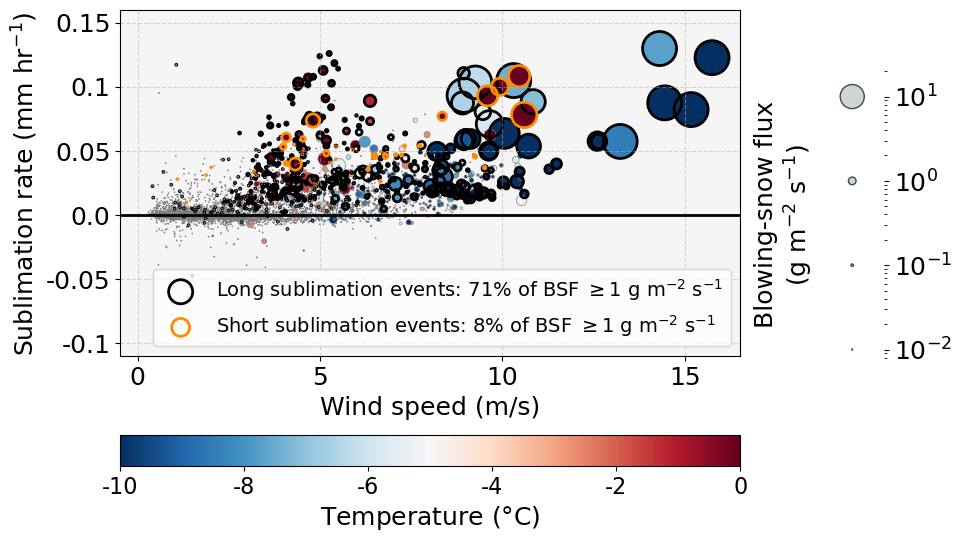

In [30]:

# ────────────────────────────────────────────────────────────────
# DATA
# ────────────────────────────────────────────────────────────────
df = sublimation_30min_df.dropna()

x       = df["wind_speed"].values
y       = df["sublimation"].values
bsf     = df["bsf"].values
temp    = df["temperature"].values

# find times during sublimation events


# ----------------------------------------------------------------
# 1) Marker‑size scaling  (log‑scale like Plotly)
# ----------------------------------------------------------------
# def bsf_to_pts2(b, min_b=0.01, max_b=30, s_min=1, s_max=2000):
#     """Map BSF (g m‑2 s‑1) to marker *area* in pt² on a log scale."""
#     logb   = np.log10(np.clip(b, min_b, None))
#     logmin = np.log10(min_b)
#     logmax = np.log10(max_b)
#     return s_min + (s_max - s_min) * (logb - logmin) / (logmax - logmin)

marker_sizes = df["bsf"].apply(lambda x: bsf_to_pts2(x)).values

# ----------------------------------------------------------------
# 2) Plot
# ----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

plot_fontsize=18
# main scatter
norm = mpl.colors.Normalize(vmin=-10, vmax=0)

sc = ax.scatter(
    x, y,
    s=marker_sizes,
    c=temp,
    cmap="RdBu_r",
    norm=norm,
    edgecolor="gray",
    linewidth=0.5,
)

# add the outline of long events in bold
sc_long = ax.scatter(
    long_events_df["wind_speed"],
    long_events_df["sublimation"],
    s=long_events_df["bsf"].apply(lambda x: bsf_to_pts2(x)).values,
    facecolor="none",
    edgecolor="black",
    linestyle="-",
    linewidth=2,
    label=f"Long sublimation events: {a*100:.0f}%"+ " of BSF $\geq$1 g m$^{-2}$ s$^{-1}$",
)

# add the outline of short events in bold
sc_short = ax.scatter(
    short_events_df["wind_speed"],
    short_events_df["sublimation"],
    s=short_events_df["bsf"].apply(lambda x: bsf_to_pts2(x)).values,
    facecolor="none",
    edgecolor="darkorange",
    linestyle="-",
    linewidth=2,
    label=f"Short sublimation events: {b*100:.0f}%"+ " of BSF $\geq$1 g m$^{-2}$ s$^{-1}$",
)

ax.axhline(0, color="black", linestyle="-", linewidth=2)

# axes labels / limits
ax.set_xlabel("Wind speed (m/s)", fontsize=plot_fontsize)
ax.set_ylabel("Sublimation rate (mm hr$^{-1}$)", fontsize=plot_fontsize)
ax.set_xticks(np.arange(0, 16, 5))
ax.set_yticks(np.arange(-0.1, 0.16, 0.05))
ax.set_xticklabels(ax.get_xticks(), fontsize=plot_fontsize)
ax.set_yticklabels(np.arange(-0.1, 0.16, 0.05).round(2), fontsize=plot_fontsize)
ax.set_ylim(-0.11, 0.16)
ax.grid(True, linestyle="--", alpha=0.5)
# add background gray
ax.set_facecolor("whitesmoke")

# add legend
ax.legend(
    handles=[sc_long, sc_short],
    loc="lower right",
    fontsize=plot_fontsize-4,
    # title="Sublimation events",
    # title_fontsize=plot_fontsize-4,
    frameon=True,
    ncol=1,
    # markerscale=1.5,
    # labelspacing=1.2,
    # handletextpad=0.5,
    # handlelength=1.5,
    # borderpad=0.5,
)

# ----------------------------------------------------------------
# 3) Colour bar (horizontal, under the scatter)
# ----------------------------------------------------------------
cbar = fig.colorbar(
    sc, ax=ax, orientation="horizontal",
    pad=0.17, fraction=0.08,
)
cbar.set_label("Temperature ($\degree$C)", fontsize=plot_fontsize)
# cbar ticks
cbar.set_ticks(np.arange(-10, 1, 2))
cbar.set_ticklabels(np.arange(-10, 1, 2).astype(int), fontsize=plot_fontsize-2)
# cbar label

# ----------------------------------------------------------------
# 4) Marker‑size legend (right‑hand mini‑axis)
# ----------------------------------------------------------------
legend_bsf   = np.array([0.01, 0.1, 1, 10])  # g m⁻² s⁻¹
legend_sizes = [bsf_to_pts2(b) for b in legend_bsf]

# position: 5 % of figure width, full height, no frame
bbox = ax.get_position()          # [x0, y0, width, height] in fig‑coords
x0   = bbox.x1 + 0.1             # little gap to the right
ax2  = fig.add_axes([x0, 0.3, 0.08, bbox.height-0.1])

ax2.scatter(
    np.zeros_like(legend_bsf), legend_bsf,
    s=legend_sizes,
    facecolor="lightgray",
    edgecolor="darkslategrey",
    linewidth=1,
)

ax2.set_yscale("log")
ax2.set_ylim(0.008, 20)
ax2.set_ylabel("Blowing‑snow flux\n(g m$^{-2}$ s$^{-1}$)", fontsize=plot_fontsize)
ax2.set_xticks([])
ax2.tick_params(axis="y", labelsize=plot_fontsize)

# make background invisible
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.yaxis.set_ticks_position("right")

# ----------------------------------------------------------------
plt.show()

# Save if needed
save_fig= True
if save_fig:
    fig.savefig("/home/dlhogan/GitHub/Synoptic-Sublimation/04_products/figures/draft/wind_speed_sublimation_bsf_temperature.png", dpi=300,
                # add some area to the bbox
                bbox_inches='tight', pad_inches=0.2, transparent=True)


In [151]:
plot_plotly_figs = False
if plot_plotly_figs:
    # create a scatter plot with the wind speed on the x-axis and the sublimation rate on the y-axis and the markers sized by the blowing snow flux (log scale)
    fig1 = px.scatter(sublimation_30min_df.dropna(), 
                    x=f'wind_speed', 
                    y=f'sublimation', 
                    size='bsf', 
                    # color by wind direction
                    color=f'temperature',
                    color_continuous_scale='RdBu_r',
                    range_color=[-10,0],
                    # make edge color black
                    # provide size scale
                        size_max=70,
                    title=f'Wind Speed and Sublimation Rate <br> sized by BSF')


    fig1.update_traces(marker=dict(
                                line=dict(width=1,
                                            color='DarkSlateGrey')),
                        text = sublimation_30min_df.dropna().index,
                        hovertemplate='Date: %{text} &deg;<br>Wind Speed: %{x} m/s<br>Sublimation Rate: %{y} mm/hr<br>Temperature: %{marker.color:.2f} &deg;C',
                    selector=dict(mode='markers'))

    df_l = sublimation_30min_df.sort_values('bsf')
    # fill df_1 with 0 for nan values
    df_l = df_l.fillna(0)

    fig2 = px.scatter(
        df_l,
        x=np.zeros(5),
        y=np.array(["0","1","5","10","50+",]),
        size=np.array([0.01,1,5,10,50]),
        size_max=40,
        # set color to gray
    )

    fig2.update_traces(marker=dict(
                                color='gray',
                                line=dict(width=1,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers'))



    fig = go.Figure(
        data=[t for t in fig1.data] + [t.update(xaxis="x2", yaxis="y2") for t in fig2.data],
        layout=fig1.layout,
    )
    # annotate path
    add_path(fig)
    # now config axes appropriately
    fig.update_layout(
        font=dict(size=16),
        xaxis_domain=[0, 0.90],
        xaxis1=dict(title='Wind Speed (m/s)',
                    ),
        yaxis1=dict(title='Sublimation Rate (mm/hr)',
                    range=[-0.05, 0.2]),
        xaxis2={"domain": [0.905, 1], "matches": None, "visible": False},
        yaxis2={"title":"Blowing Snow Flux (g/m<sup>2</sup>/s)","anchor": "free", "overlaying": "y", "side": "right", "position": 1},
        showlegend=False,
        height=600, width=1000,
        coloraxis_colorbar_title_text ='Temperature (&deg;C)'
    )

    # size the legend in a log scale
    fig.update_layout(legend=dict(itemsizing='constant',))
    # move the colorbar axis to the right, flip orientation
    fig.update_layout(coloraxis_colorbar=dict(yanchor="top", 
                                            y=-0.2, 
                                            x=-0.05, 
                                            xanchor="left", 
                                            title='Temperature (&deg;C)',
                                            orientation='h'),
                                            )
    # increase text size for labels and axes
    save_fig = False
    if save_fig:
        fig.write_image('./04_products/figures/draft/wind_speed_sublimation_bsf_temperature.png')

In [27]:
fig

In [10]:

# create a scatter plot with the wind speed on the x-axis and the sublimation rate on the y-axis and the markers sized by the blowing snow flux (log scale)
fig1 = px.scatter(sublimation_30min_df.dropna(), 
                 x=f'wind_speed', 
                 y=f'sublimation', 
                 size='bsf', 
                 # color by wind direction
                 color=f'wind_direction',
                 color_continuous_scale='twilight',
                #  range_color=[0,360],
                 # make edge color black
                 # provide size scale
                 size_max=70,
                 title=f'')


fig1.update_traces(marker=dict(
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                    text = sublimation_30min_df.dropna().index,
                    hovertemplate='Date: %{text} &deg;<br>Wind Speed: %{x} m/s<br>Sublimation Rate: %{y} mm/hr<br>Wind Direction: %{marker.color:.2f} &deg;C',
                  selector=dict(mode='markers'))

df_l = sublimation_30min_df.sort_values('bsf')
# fill df_1 with 0 for nan values
df_l = df_l.fillna(0)

fig2 = px.scatter(
    df_l,
    x=np.zeros(5),
    y=np.array(["0","1","5","10","50+",]),
    size=np.array([0.01,1,5,10,50]),
    size_max=40,
    # set color to gray
)

fig2.update_traces(marker=dict(
                            color='gray',
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))



fig = go.Figure(
    data=[t for t in fig1.data] + [t.update(xaxis="x2", yaxis="y2") for t in fig2.data],
    layout=fig1.layout,
)
add_path(fig)
# now config axes appropriately
fig.update_layout(
    font=dict(size=16),
    xaxis_domain=[0, 0.90],
    xaxis1=dict(title='Wind Speed (m/s)',
                ),
    yaxis1=dict(title='Sublimation Rate (mm/hr)',
                range=[-0.05, 0.2]),
    xaxis2={"domain": [0.905, 1], "matches": None, "visible": False},
    yaxis2={"title":"Blowing Snow Flux (g/m^2/s)","anchor": "free", "overlaying": "y", "side": "right", "position": 1},
    showlegend=False,
    height=600, width=1000,
    coloraxis_colorbar_title_text ='Wind Direction (&deg;)'
)

# size the legend in a log scale
fig.update_layout(legend=dict(itemsizing='constant',))
# move the colorbar axis to the right, flip orientation
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", 
                                          y=-0.2, 
                                          x=-0.05, 
                                          xanchor="left", 
                                          title='Wind Direction (&deg;)',
                                          orientation='h'))
save_fig = False
if save_fig:
    fig.write_image('../04_products/figures/draft/wind_speed_sublimation_bsf_wind_dir.png')